In [1]:
!pip install -U datasets huggingface_hub transformers[torch] evaluate peft bitsandbytes trl --quiet

In [3]:
from transformers import TrainingArguments, Trainer
import torch

2024-05-26 16:06:06.735752: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-26 16:06:06.735903: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-26 16:06:06.873174: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
from datasets import load_dataset

dataset = load_dataset("nyu-mll/multi_nli")

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

In [6]:
from transformers import BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=False,
)

In [7]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.add_eos_token = True

model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Meta-Llama-3-8B",
    quantization_config=bnb_config,
    device_map="auto",
)

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/177 [00:00<?, ?B/s]

In [8]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

model = prepare_model_for_kbit_training(model)

In [9]:
import evaluate

accuracy = evaluate.load("accuracy")

In [10]:
def tokenize_func(examples):
    return tokenizer(examples['text'], truncation=True, padding=True, max_length=512)

In [11]:
train_len = len(dataset['train'])
train_set = dataset['train'].filter(lambda example, idx: idx < train_len * 0.1, with_indices=True)

Filter:   0%|          | 0/392702 [00:00<?, ? examples/s]

In [12]:
train_set

Dataset({
    features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
    num_rows: 39271
})

In [13]:
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [14]:
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
)

In [15]:
model.config.use_cache = False

In [16]:
def formatting_prompts_func(examples):
    output_texts = [] 
    label_mapping = {
        0: 'entailment',
        1: 'neutral',
        2: 'contradict'
    }
    
    for i in range(len(examples['label'])):
        output_texts.append(f'''Using the *premise* and the *hypothesis*:
- If the *premise* logically implies the negation or opposite of the *hypothesis* (i.e., they are contradicting), then the *Sentence Label* should be equal to 2.
- If the *premise* does not provide enough information to determine if the *hypothesis* is true or false (i.e., they are neutral), then the *Sentence Label* should be equal to 1.
- If the *premise* logically implies or entails the *hypothesis*, then the *Sentence Label* should be equal to 0.
- The sentence label should end with 0, 1, or 2. (e.g. Sentence label = 1)
------------------
Premise: "{examples['premise'][i].strip()}"
Hypothesis: "{examples['hypothesis'][i].strip()}"
Sentence label = {examples['label'][i]}''')

    return output_texts

In [17]:
from trl import SFTTrainer

In [18]:
len(train_set)

39271

In [19]:
from trl import DataCollatorForCompletionOnlyLM

response_template = "Sentence label = "
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

In [24]:
training_args = TrainingArguments(
    output_dir = './result',
    save_steps=0.9,
    learning_rate=2e-4,
    num_train_epochs=1,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=0.1,
    weight_decay=0.01,
    report_to='none',
    overwrite_output_dir=True,
    fp16=False,
    optim="paged_adamw_8bit",
    max_steps=1000,
    logging_steps=0.25,
)


trainer = SFTTrainer(
    model=model,
    train_dataset=train_set,
    peft_config=peft_config,
    tokenizer=tokenizer,
    args=training_args,
    formatting_func=formatting_prompts_func,
    max_seq_length=512,
    packing=False,
    data_collator=collator,
)

Map:   0%|          | 0/39271 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


In [25]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [26]:
print_trainable_parameters(trainer.model)

trainable params: 27262976 || all params: 4567863296 || trainable%: 0.5968430803057028


In [27]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
250,0.646900
500,0.471600
750,0.462900
1000,0.367700


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


TrainOutput(global_step=1000, training_loss=0.4872716751098633, metrics={'train_runtime': 6793.1591, 'train_samples_per_second': 0.589, 'train_steps_per_second': 0.147, 'total_flos': 4.214909770068787e+16, 'train_loss': 0.4872716751098633, 'epoch': 0.10185373803218578})

In [28]:
trainer.model.save_pretrained("./qlora_adapter")

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [29]:
def generate_instructions(example):
    example['prompt'] = f'''Textual Entailment Task:
- If the *premise* logically implies the negation or opposite of the *hypothesis* (i.e., they are contradicting), then the *Sentence Label* should be equal to 2.
- If the *premise* does not provide enough information to determine if the *hypothesis* is true or false (i.e., they are neutral), then the *Sentence Label* should be equal to 1.
- If the *premise* logically implies or entails the *hypothesis*, then the *Sentence Label* should be equal to 0.
- The sentence label should end with 0, 1, or 2. (e.g. Sentence label = 1)
------------------
Premise: "{example['premise']}"
Hypothesis: "{example['hypothesis']}"
Sentence label = '''

    return example

dataset = dataset.map(generate_instructions)

Map:   0%|          | 0/392702 [00:00<?, ? examples/s]

Map:   0%|          | 0/9815 [00:00<?, ? examples/s]

Map:   0%|          | 0/9832 [00:00<?, ? examples/s]

In [30]:
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B", padding_side='left')
tokenizer.pad_token = tokenizer.eos_token
tokenizer.add_eos_token = True

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [31]:
def predict(examples):
    tokenized = tokenizer(examples, return_tensors='pt', truncation=True, padding=True, max_length=512).to(device)
    output = trainer.model.generate(**tokenized, pad_token_id=tokenizer.pad_token_id, max_new_tokens=1, temperature=0.01, tokenizer=tokenizer)
    texts = tokenizer.batch_decode(output)

    #print('\n'.join(texts))

    # TODO: Handel cases where model doesn't like to follow the instructions
    predictions = [int(text[-1]) if text[-1] in ['0', '1', '2'] else -1 for text in texts]

    return predictions

In [32]:
from tqdm import tqdm

predictions = []
references = []
trainer.model.eval()

dataset_len = round(len(dataset['validation_matched']) * 1.0)

with torch.no_grad():
    for i in tqdm(range(0, dataset_len, 8)):
        examples = dataset['validation_matched'][i + 0:i + 8]
        prediction = predict(examples['prompt'])

        reference = examples['label']

        predictions += prediction
        references += reference

100%|██████████| 1227/1227 [1:21:03<00:00,  3.96s/it]


In [33]:
erroneous_indices = [i for i, p in enumerate(predictions) if p == -1]
print(len(erroneous_indices))
predictions_fixed = [p for i, p in enumerate(predictions) if not i in erroneous_indices]
references_fixed = [r for i, r in enumerate(references) if not i in erroneous_indices]

0


In [35]:
accuracy.compute(predictions=predictions_fixed, references=references_fixed)

{'accuracy': 0.8843606724401426}

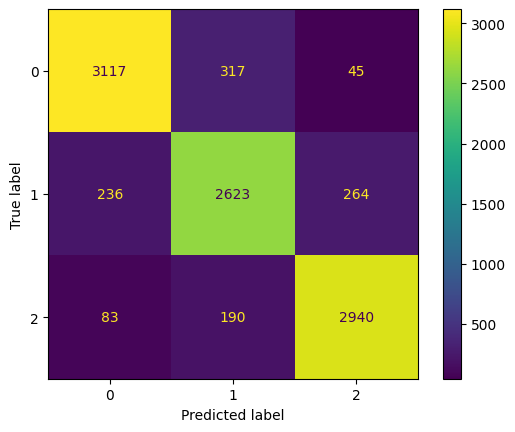

In [36]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

matrix = confusion_matrix(y_true=references_fixed, y_pred=predictions_fixed, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot()
plt.show()

In [37]:
predictions = []
references = []
trainer.model.eval()

dataset_len = round(len(dataset['validation_mismatched']) * 1.0)

with torch.no_grad():
    for i in tqdm(range(0, dataset_len, 8)):
        examples = dataset['validation_mismatched'][i + 0:i + 8]
        prediction = predict(examples['prompt'])

        reference = examples['label']

        predictions += prediction
        references += reference

100%|██████████| 1227/1227 [1:21:03<00:00,  3.96s/it]


In [38]:
erroneous_indices = [i for i, p in enumerate(predictions) if p == -1]
print(len(erroneous_indices))
predictions_fixed = [p for i, p in enumerate(predictions) if not i in erroneous_indices]
references_fixed = [r for i, r in enumerate(references) if not i in erroneous_indices]

0


In [39]:
accuracy.compute(predictions=predictions_fixed, references=references_fixed)

{'accuracy': 0.8840550178298523}

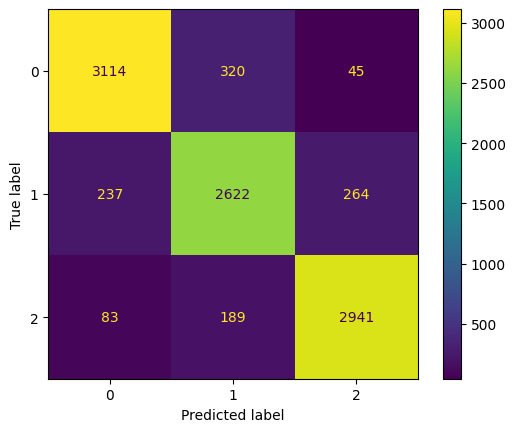

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

matrix = confusion_matrix(y_true=references_fixed, y_pred=predictions_fixed, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot()
plt.show()